In [1]:
from jyro.simulator import (Canvas, Physics, Pioneer, Pioneer16Sonars, PioneerFrontLightSensors,
                            Camera, Simulator, VSimulator, DepthCamera, MyroIR, Color, SequenceViewer, MyroBumper)
import numpy as np
from math import pi
from random import random
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from maps.map import Map

## Map

Map dimensions: 25 x 25 meters
Obstacle ratio: 0.3712


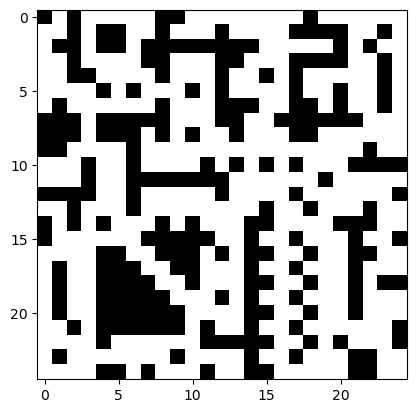

In [2]:
map = Map()
map_arr = map.load_map('maps/saved_maps/map_3.npy')
map.display()

print(f'Map dimensions: {map_arr.shape[0]} x {map_arr.shape[1]} meters')
print(f'Obstacle ratio: {map.get_obstacle_ratio()}')

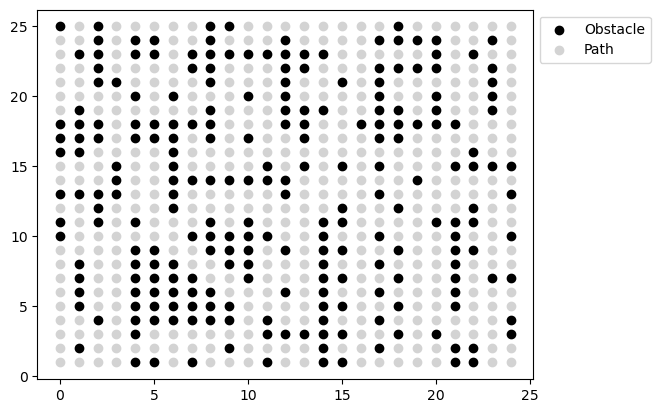

In [3]:
# Get Cartesian coordinates
cartesian_coords = map.image_to_cartesian()
obstacle_coords = cartesian_coords[1]
path_coords = cartesian_coords[0]


assert len(obstacle_coords)+len(path_coords) == np.prod(map_arr.shape)

# Plot to confirm
plt.scatter(obstacle_coords[:, 0], obstacle_coords[:, 1], color='black', label='Obstacle')
plt.scatter(path_coords[:, 0], path_coords[:, 1], color='lightgray', label='Path')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.show()

In [4]:
# Get upper left and lower right coordinates for each obstacle box
obstacle_boxes = []
for o_p in obstacle_coords:
    ul_x, ul_y = o_p
    lr_x = ul_x + 1
    lr_y = ul_y - 1
    obstacle_boxes.append((ul_x, ul_y, lr_x, lr_y))

## World

In [11]:
sim = Physics()

def make_world(sim):
    sim.addBox(0, 0, 25, 25, fill='white', wallcolor="black")
    
    for i in obstacle_boxes:
        ul_x, ul_y, lr_x, lr_y = i
        sim.addBox(ul_x, ul_y, lr_x, lr_y, fill='black')

make_world(sim)

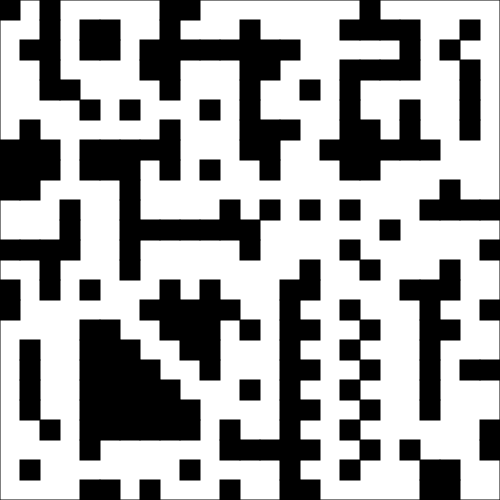

In [12]:
canvas = Canvas((500, 500))
sim.draw(canvas)